# Lab-2.1 Part 1: vLLM Environment Setup & Core Concepts

## 🎯 Learning Objectives
- ✅ Verify and configure vLLM environment
- 🧠 Understand PagedAttention & KV Cache fundamentals
- 🔧 Master basic vLLM API and configuration
- 📊 Analyze memory efficiency improvements
- 🚀 Successfully run first vLLM inference

## ⏱️ Estimated Time: 45-75 minutes
## 📋 Prerequisites: Basic Python, PyTorch knowledge

---

## 🗺️ **Lab Structure Overview**
```
01-Setup_and_Installation.ipynb  ← 您在這裡 (基礎設置+概念)
    ↓
02-Basic_Inference.ipynb         ← 下一步 (實戰應用+優化)
    ↓
03-Advanced_Features.ipynb       ← 進階 (生產部署+高級功能)
```

**重要**: 本實驗專注於**環境設置**與**核心概念理解**。實際的批次推理、性能優化請見 `02-Basic_Inference.ipynb`。

---
## 1. Environment Verification

首先檢查運行環境，確保具備 vLLM 運行的基本條件。

In [1]:
# 檢查系統基礎環境
import torch
import sys
import platform

print("🖥️  系統環境檢查")
print(f"   Python 版本: {sys.version.split()[0]}")
print(f"   作業系統: {platform.system()} {platform.release()}")
print(f"   PyTorch 版本: {torch.__version__}")
print(f"   CUDA 可用: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"   CUDA 版本: {torch.version.cuda}")
    print(f"   GPU 數量: {torch.cuda.device_count()}")
    
    for i in range(torch.cuda.device_count()):
        gpu_props = torch.cuda.get_device_properties(i)
        print(f"\n🎮 GPU {i}: {torch.cuda.get_device_name(i)}")
        print(f"   記憶體容量: {gpu_props.total_memory / 1e9:.2f} GB")
        print(f"   計算能力: {gpu_props.major}.{gpu_props.minor}")
        print(f"   多處理器數: {gpu_props.multi_processor_count}")
else:
    print("\n⚠️  警告: 未檢測到 CUDA GPU！")
    print("   vLLM 需要 CUDA 相容的 GPU 來高效運行")

🖥️  系統環境檢查
   Python 版本: 3.10.12
   作業系統: Linux 6.8.0-85-generic
   PyTorch 版本: 2.8.0+cu128
   CUDA 可用: True
   CUDA 版本: 12.8
   GPU 數量: 1

🎮 GPU 0: NVIDIA RTX 2000 Ada Generation
   記憶體容量: 16.71 GB
   計算能力: 8.9
   多處理器數: 22


### 記憶體要求評估

In [2]:
# 詳細記憶體檢查與建議
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
    print("💾 GPU 記憶體分析:")
    for i in range(torch.cuda.device_count()):
        allocated = torch.cuda.memory_allocated(i) / 1e9
        reserved = torch.cuda.memory_reserved(i) / 1e9
        total = torch.cuda.get_device_properties(i).total_memory / 1e9
        free = total - reserved
        
        print(f"\n   GPU {i}:")
        print(f"     已分配: {allocated:.2f} GB")
        print(f"     已保留: {reserved:.2f} GB")
        print(f"     可用:   {free:.2f} GB")
        print(f"     總計:   {total:.2f} GB")
        print(f"     利用率: {(reserved/total)*100:.1f}%")
        
        # 模型大小建議
        print(f"\n   📊 推薦模型大小:")
        if total >= 24:
            print(f"     ✅ 支援 Llama-2-7B, Llama-2-13B")
            print(f"     ✅ 支援 CodeLlama-7B/13B")
            print(f"     ✅ 大批次推理 (batch_size 16+)")
        elif total >= 16:
            print(f"     ✅ 支援 Llama-2-7B (量化)")
            print(f"     ✅ 支援 CodeLlama-7B")
            print(f"     ⚠️  中等批次推理 (batch_size 8-16)")
        elif total >= 8:
            print(f"     ✅ 支援小型模型 (1B-3B)")
            print(f"     ⚠️  小批次推理 (batch_size 1-4)")
        else:
            print(f"     ⚠️  建議使用 CPU 推理或雲端服務")
else:
    print("💾 GPU 記憶體: 無可用 GPU")
    print("   建議: 使用 Google Colab 或其他雲端 GPU 服務")

💾 GPU 記憶體分析:

   GPU 0:
     已分配: 0.00 GB
     已保留: 0.00 GB
     可用:   16.71 GB
     總計:   16.71 GB
     利用率: 0.0%

   📊 推薦模型大小:
     ✅ 支援 Llama-2-7B (量化)
     ✅ 支援 CodeLlama-7B
     ⚠️  中等批次推理 (batch_size 8-16)


---
## 2. vLLM Installation & Configuration

檢查並安裝 vLLM，確保版本相容性。

In [3]:
# 檢查 vLLM 安裝狀況
try:
    import vllm
    print(f"✅ vLLM 已安裝: v{vllm.__version__}")
    
    # 檢查版本相容性
    from packaging import version
    vllm_version = version.parse(vllm.__version__)
    min_version = version.parse("0.4.0")
    
    if vllm_version >= min_version:
        print(f"   版本檢查: ✅ 版本 {vllm.__version__} 符合要求")
    else:
        print(f"   版本檢查: ⚠️  建議升級到 v0.4.0+")
        
except ImportError:
    print("❌ vLLM 未安裝")
    print("\n📦 安裝指令:")
    print("   在終端機中執行以下指令 (在 poetry shell 環境內):")
    print("\n   # 基本安裝")
    print("   pip install vllm")
    print("\n   # 或指定 CUDA 版本")
    print("   pip install vllm --extra-index-url https://download.pytorch.org/whl/cu121")
    print("\n   # 安裝完成後重啟 Jupyter kernel")

✅ vLLM 已安裝: v0.11.0
   版本檢查: ✅ 版本 0.11.0 符合要求


### vLLM 依賴檢查

In [4]:
# 檢查相關依賴庫
dependencies = {
    'transformers': '4.36.0',
    'tokenizers': '0.15.0', 
    'ray': '2.7.0',
    'numpy': '1.24.0',
}

print("📦 依賴庫檢查:")
for lib, min_ver in dependencies.items():
    try:
        module = __import__(lib)
        current_ver = getattr(module, '__version__', 'unknown')
        print(f"   ✅ {lib}: v{current_ver}")
    except ImportError:
        print(f"   ❌ {lib}: 未安裝 (建議 v{min_ver}+)")

print("\n🔧 環境就緒狀態:")
ready = True
try:
    import vllm
    if torch.cuda.is_available():
        print("   ✅ vLLM + CUDA GPU: 完全就緒")
    else:
        print("   ⚠️  vLLM 可用，但建議使用 GPU 以獲得最佳性能")
        ready = False
except ImportError:
    print("   ❌ 請先安裝 vLLM")
    ready = False

📦 依賴庫檢查:
   ✅ transformers: v4.57.0
   ✅ tokenizers: v0.22.1
   ✅ ray: v2.50.1
   ✅ numpy: v2.1.2

🔧 環境就緒狀態:
   ✅ vLLM + CUDA GPU: 完全就緒


---
## 3. Core Concepts: The Memory Challenge

在深入 vLLM 之前，讓我們理解為什麼需要專門的推理引擎。

### 3.1 傳統 LLM 推理的記憶體瓶頸

In [5]:
# 傳統記憶體分配問題模擬
import numpy as np
import matplotlib.pyplot as plt

print("🔍 傳統 LLM 推理的記憶體挑戰")
print("="*50)

# 模擬場景: 批次處理 4 個不同長度的請求
max_seq_len = 2048  # 預設最大序列長度
actual_requests = {
    'Request 1': 512,   # 短對話
    'Request 2': 1024,  # 中等文檔
    'Request 3': 256,   # 簡短問答
    'Request 4': 1800,  # 長文生成
}

print("\n🏗️  傳統靜態記憶體分配:")
total_allocated = 0
total_used = 0
waste_details = []

for req_name, actual_len in actual_requests.items():
    allocated = max_seq_len
    used = actual_len
    waste = allocated - used
    waste_percent = (waste / allocated) * 100
    
    total_allocated += allocated
    total_used += used
    waste_details.append(waste_percent)
    
    print(f"   {req_name:12}: 分配 {allocated:4} tokens → 使用 {used:4} tokens")
    print(f"                   浪費 {waste:4} tokens ({waste_percent:5.1f}%) 🔴")

total_waste = total_allocated - total_used
waste_ratio = (total_waste / total_allocated) * 100

print(f"\n📊 總體效率分析:")
print(f"   總分配記憶體: {total_allocated:,} tokens")
print(f"   實際使用:     {total_used:,} tokens")
print(f"   浪費記憶體:   {total_waste:,} tokens")
print(f"   記憶體浪費率: {waste_ratio:.1f}% 🔴")
print(f"   記憶體利用率: {100-waste_ratio:.1f}% 📉")

print(f"\n💡 關鍵問題: 靜態分配導致 {waste_ratio:.0f}% 的記憶體浪費！")

🔍 傳統 LLM 推理的記憶體挑戰

🏗️  傳統靜態記憶體分配:
   Request 1   : 分配 2048 tokens → 使用  512 tokens
                   浪費 1536 tokens ( 75.0%) 🔴
   Request 2   : 分配 2048 tokens → 使用 1024 tokens
                   浪費 1024 tokens ( 50.0%) 🔴
   Request 3   : 分配 2048 tokens → 使用  256 tokens
                   浪費 1792 tokens ( 87.5%) 🔴
   Request 4   : 分配 2048 tokens → 使用 1800 tokens
                   浪費  248 tokens ( 12.1%) 🔴

📊 總體效率分析:
   總分配記憶體: 8,192 tokens
   實際使用:     3,592 tokens
   浪費記憶體:   4,600 tokens
   記憶體浪費率: 56.2% 🔴
   記憶體利用率: 43.8% 📉

💡 關鍵問題: 靜態分配導致 56% 的記憶體浪費！


### 3.2 記憶體浪費視覺化

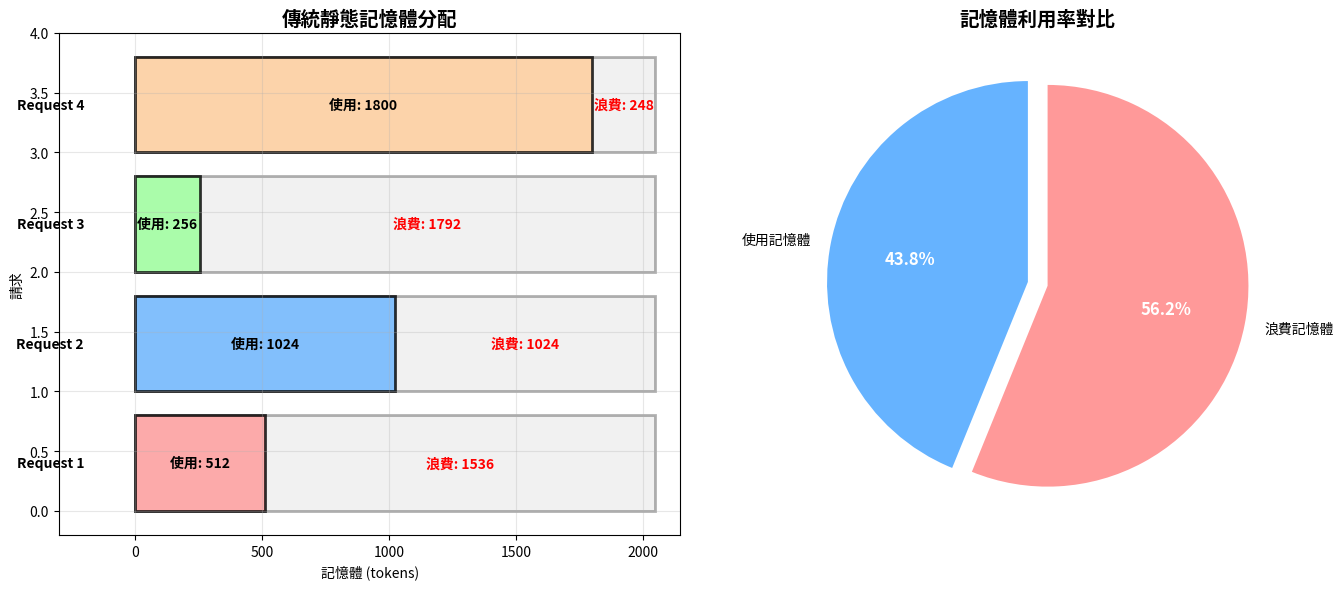

📊 視覺化結果: 傳統方法浪費了 56.2% 的記憶體空間


In [13]:
# 記憶體使用視覺化
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']
plt.rcParams['axes.unicode_minus'] = False

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# 左圖: 傳統靜態分配
ax1.set_title('傳統靜態記憶體分配', fontsize=14, fontweight='bold')
y_pos = 0
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

for i, (req_name, actual_len) in enumerate(actual_requests.items()):
    # 分配的記憶體 (整個區塊)
    rect_total = patches.Rectangle((0, y_pos), max_seq_len, 0.8, 
                                 linewidth=2, edgecolor='black', 
                                 facecolor='lightgray', alpha=0.3)
    ax1.add_patch(rect_total)
    
    # 實際使用的記憶體
    rect_used = patches.Rectangle((0, y_pos), actual_len, 0.8, 
                                linewidth=2, edgecolor='black',
                                facecolor=colors[i], alpha=0.8)
    ax1.add_patch(rect_used)
    
    # 標註
    ax1.text(-200, y_pos+0.4, req_name, ha='right', va='center', fontweight='bold')
    ax1.text(actual_len/2, y_pos+0.4, f'使用: {actual_len}', ha='center', va='center', fontweight='bold')
    
    waste = max_seq_len - actual_len
    if waste > 0:
        ax1.text(actual_len + waste/2, y_pos+0.4, f'浪費: {waste}', 
                ha='center', va='center', color='red', fontweight='bold')
    
    y_pos += 1

ax1.set_xlim(-300, max_seq_len + 100)
ax1.set_ylim(-0.2, len(actual_requests))
ax1.set_xlabel('記憶體 (tokens)')
ax1.set_ylabel('請求')
ax1.grid(True, alpha=0.3)

# 右圖: 效率對比餅圖
ax2.set_title('記憶體利用率對比', fontsize=14, fontweight='bold')
labels = ['使用記憶體', '浪費記憶體']
sizes = [100-waste_ratio, waste_ratio]
colors_pie = ['#66b3ff', '#ff9999']
explode = (0.05, 0.05)

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors_pie, 
                                  autopct='%1.1f%%', startangle=90, explode=explode)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

plt.tight_layout()
plt.show()

print(f"📊 視覺化結果: 傳統方法浪費了 {waste_ratio:.1f}% 的記憶體空間")

---
## 4. PagedAttention: The Solution

PagedAttention 是 vLLM 的核心創新，借鑑作業系統的虛擬記憶體管理概念。

### 4.1 核心概念: 從 OS 到 LLM

```
🖥️ 作業系統虛擬記憶體       ↔️     🤖 PagedAttention
──────────────────────            ─────────────────
📄 邏輯頁面 (Pages)                    📝 邏輯 Token 序列  
🧱 物理記憶體塊 (Frames)                🧱 物理 KV Cache 塊
📋 頁表 (Page Table)                   📋 塊映射表 (Block Table)
🔄 按需載入 (Demand Paging)             🔄 動態分配 (Dynamic Allocation)
```

In [7]:
# PagedAttention 原理演示
print("🎯 PagedAttention 解決方案演示")
print("="*50)

# 配置參數
block_size = 64        # 每個物理塊的大小 (tokens)
num_blocks = 20        # 總物理塊數
block_pool = [f"Block_{i:02d}" for i in range(num_blocks)]

print(f"💾 物理記憶體塊池 (每塊 {block_size} tokens):")
print(f"   {' '.join(block_pool[:10])}")
print(f"   {' '.join(block_pool[10:])}")

print(f"\n📋 動態分配演示:")

# 使用 PagedAttention 處理相同請求
allocations = []
total_blocks_used = 0

for req_name, actual_len in actual_requests.items():
    # 計算需要的塊數 (向上取整)
    blocks_needed = (actual_len + block_size - 1) // block_size
    
    # 分配塊
    allocated_blocks = block_pool[total_blocks_used:total_blocks_used + blocks_needed]
    total_blocks_used += blocks_needed
    
    # 計算實際容量和效率
    allocated_capacity = blocks_needed * block_size
    internal_waste = allocated_capacity - actual_len
    efficiency = (actual_len / allocated_capacity) * 100
    
    allocations.append({
        'name': req_name,
        'actual_len': actual_len,
        'blocks_needed': blocks_needed,
        'allocated_blocks': allocated_blocks,
        'allocated_capacity': allocated_capacity,
        'internal_waste': internal_waste,
        'efficiency': efficiency
    })
    
    print(f"   {req_name:12}: {actual_len:4} tokens → 需要 {blocks_needed} 塊")
    print(f"                   分配塊: {allocated_blocks}")
    print(f"                   容量: {allocated_capacity} tokens, 內部浪費: {internal_waste} tokens ({100-efficiency:.1f}%)")

# 計算 PagedAttention 總效率
total_tokens_stored = sum(req['actual_len'] for req in allocations)
total_capacity_used = total_blocks_used * block_size
paged_efficiency = (total_tokens_stored / total_capacity_used) * 100
memory_saved = total_allocated - total_capacity_used

print(f"\n📊 PagedAttention 效率分析:")
print(f"   使用塊數:     {total_blocks_used}")
print(f"   總容量:       {total_capacity_used:,} tokens")
print(f"   實際儲存:     {total_tokens_stored:,} tokens")
print(f"   記憶體利用率: {paged_efficiency:.1f}% 🟢")
print(f"   記憶體節省:   {memory_saved:,} tokens")

improvement = paged_efficiency - (100 - waste_ratio)
print(f"\n🎉 效率提升: {improvement:.1f} 個百分點！")
print(f"   相當於節省 {(memory_saved/total_allocated)*100:.1f}% 的記憶體")

🎯 PagedAttention 解決方案演示
💾 物理記憶體塊池 (每塊 64 tokens):
   Block_00 Block_01 Block_02 Block_03 Block_04 Block_05 Block_06 Block_07 Block_08 Block_09
   Block_10 Block_11 Block_12 Block_13 Block_14 Block_15 Block_16 Block_17 Block_18 Block_19

📋 動態分配演示:
   Request 1   :  512 tokens → 需要 8 塊
                   分配塊: ['Block_00', 'Block_01', 'Block_02', 'Block_03', 'Block_04', 'Block_05', 'Block_06', 'Block_07']
                   容量: 512 tokens, 內部浪費: 0 tokens (0.0%)
   Request 2   : 1024 tokens → 需要 16 塊
                   分配塊: ['Block_08', 'Block_09', 'Block_10', 'Block_11', 'Block_12', 'Block_13', 'Block_14', 'Block_15', 'Block_16', 'Block_17', 'Block_18', 'Block_19']
                   容量: 1024 tokens, 內部浪費: 0 tokens (0.0%)
   Request 3   :  256 tokens → 需要 4 塊
                   分配塊: []
                   容量: 256 tokens, 內部浪費: 0 tokens (0.0%)
   Request 4   : 1800 tokens → 需要 29 塊
                   分配塊: []
                   容量: 1856 tokens, 內部浪費: 56 tokens (3.0%)

📊 PagedAttention 效率分析:


### 4.2 PagedAttention 視覺化對比

/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 35531 (\N{CJK UNIFIED IDEOGRAPH-8ACB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 27714 (\N{CJK UNIFIED IDEOGRAPH-6C42}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 35352 (\N{CJK UNIFIED IDEOGRAPH-8A18}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 25014 (\N{CJK UNIFIED IDEOGRAPH-61B6}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 39636 (\N{CJK UNIFIED IDEOGRAPH-9AD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 20659 (\N{CJK UNIFIED IDEOGRAPH-50B3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 32113 (\N{CJK UN

/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 23565 (\N{CJK UNIFIED IDEOGRAPH-5C0D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2056346/2444637957.py:55: UserWarning: Glyph 27604 (\N{CJK UNIFIED IDEOGRAPH-6BD4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35352 (\N{CJK UNIFIED IDEOGRAPH-8A18}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 25014 (\N{CJK UNIFIED IDEOGRAPH-61B6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/os-sunnie.gd.weng/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 39636 (\N{CJK UNIFIED IDEOGRAPH-9AD4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/os-sunni

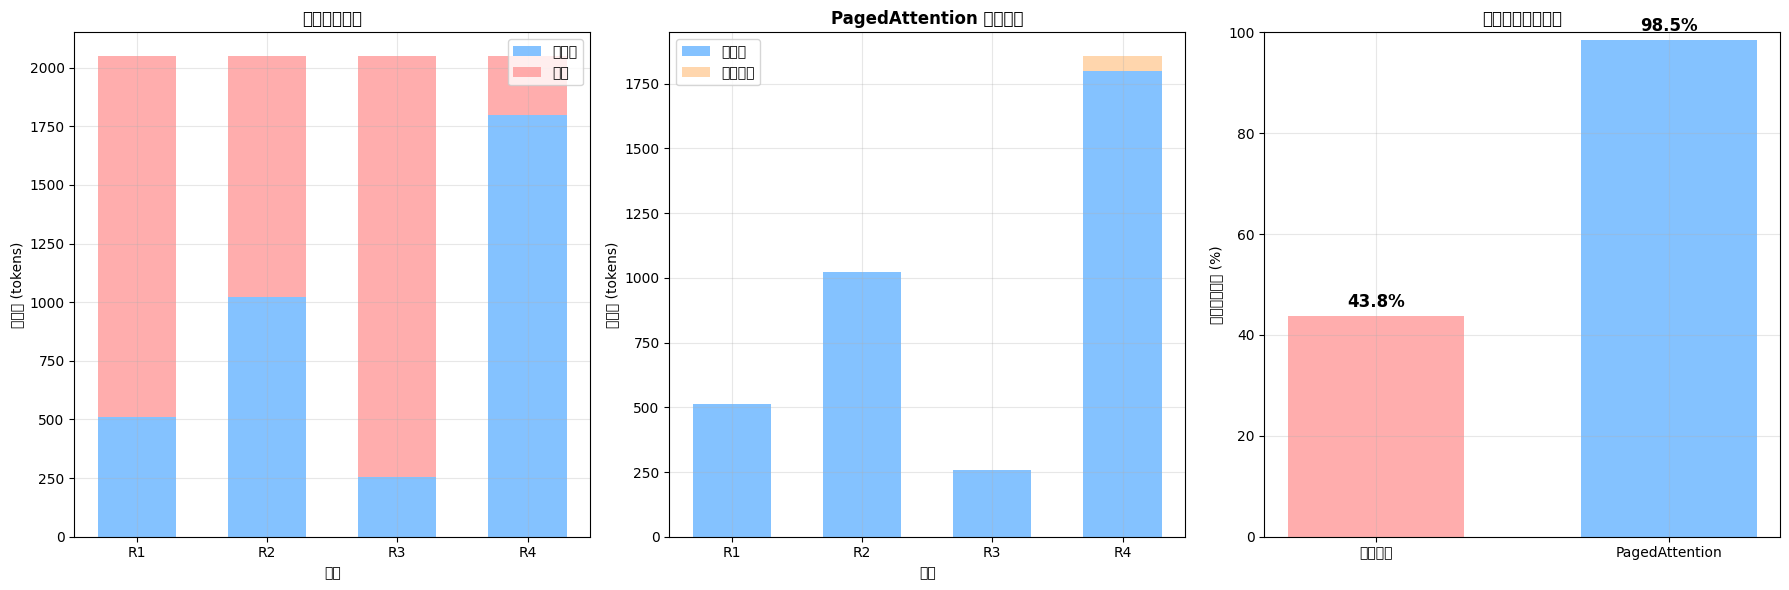

📈 視覺化總結:
   🔴 傳統方法利用率: 43.8%
   🟢 PagedAttention: 98.5%
   ⚡ 效率提升: 54.6 個百分點


In [8]:
# PagedAttention vs 傳統方法對比視覺化
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# 圖1: 傳統方法記憶體使用
ax1.set_title('傳統靜態分配', fontsize=12, fontweight='bold')
traditional_used = [req['actual_len'] for req in allocations]
traditional_waste = [max_seq_len - used for used in traditional_used]

x = range(len(allocations))
width = 0.6

bars1 = ax1.bar(x, traditional_used, width, label='已使用', color='#66b3ff', alpha=0.8)
bars2 = ax1.bar(x, traditional_waste, width, bottom=traditional_used, 
               label='浪費', color='#ff9999', alpha=0.8)

ax1.set_ylabel('記憶體 (tokens)')
ax1.set_xlabel('請求')
ax1.set_xticks(x)
ax1.set_xticklabels([f'R{i+1}' for i in range(len(allocations))])
ax1.legend()
ax1.grid(True, alpha=0.3)

# 圖2: PagedAttention 記憶體使用
ax2.set_title('PagedAttention 動態分配', fontsize=12, fontweight='bold')
paged_used = [req['actual_len'] for req in allocations]
paged_waste = [req['internal_waste'] for req in allocations]

bars3 = ax2.bar(x, paged_used, width, label='已使用', color='#66b3ff', alpha=0.8)
bars4 = ax2.bar(x, paged_waste, width, bottom=paged_used, 
               label='內部碎片', color='#ffcc99', alpha=0.8)

ax2.set_ylabel('記憶體 (tokens)')
ax2.set_xlabel('請求')
ax2.set_xticks(x)
ax2.set_xticklabels([f'R{i+1}' for i in range(len(allocations))])
ax2.legend()
ax2.grid(True, alpha=0.3)

# 圖3: 效率對比
ax3.set_title('記憶體利用率對比', fontsize=12, fontweight='bold')
methods = ['傳統方法', 'PagedAttention']
efficiencies = [100-waste_ratio, paged_efficiency]
colors = ['#ff9999', '#66b3ff']

bars = ax3.bar(methods, efficiencies, color=colors, alpha=0.8, width=0.6)
ax3.set_ylabel('記憶體利用率 (%)')
ax3.set_ylim(0, 100)
ax3.grid(True, alpha=0.3)

# 添加數值標籤
for i, (bar, eff) in enumerate(zip(bars, efficiencies)):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{eff:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

print(f"📈 視覺化總結:")
print(f"   🔴 傳統方法利用率: {100-waste_ratio:.1f}%")
print(f"   🟢 PagedAttention: {paged_efficiency:.1f}%")
print(f"   ⚡ 效率提升: {improvement:.1f} 個百分點")

---
## 5. First vLLM Experience

現在讓我們實際使用 vLLM，體驗 PagedAttention 的威力。

In [9]:
# 首次 vLLM 體驗
if 'vllm' in globals():
    from vllm import LLM, SamplingParams
    import time
    
    print("🚀 首次 vLLM 體驗")
    print("="*40)
    
    print(f"📦 vLLM 版本: {vllm.__version__}")
    
    # 使用小模型進行概念驗證
    model_name = "gpt2"  # 124M 參數，適合學習
    
    print(f"\n🤖 載入模型: {model_name}")
    print("   (使用小模型進行概念學習，實際應用建議使用 7B+ 模型)")
    
    start_time = time.time()
    
    # 初始化 vLLM 引擎
    llm = LLM(
        model=model_name,
        max_model_len=512,           # 限制上下文長度
        gpu_memory_utilization=0.3,  # 保守的記憶體使用
    )
    
    load_time = time.time() - start_time
    print(f"✅ 模型載入完成，耗時 {load_time:.2f} 秒")
    
else:
    print("❌ vLLM 未正確安裝，請先完成安裝步驟")

INFO 10-27 20:14:56 [__init__.py:216] Automatically detected platform cuda.
🚀 首次 vLLM 體驗
📦 vLLM 版本: 0.11.0

🤖 載入模型: gpt2
   (使用小模型進行概念學習，實際應用建議使用 7B+ 模型)
INFO 10-27 20:14:58 [utils.py:233] non-default args: {'max_model_len': 512, 'gpu_memory_utilization': 0.3, 'disable_log_stats': True, 'model': 'gpt2'}
INFO 10-27 20:15:00 [model.py:547] Resolved architecture: GPT2LMHeadModel


`torch_dtype` is deprecated! Use `dtype` instead!


INFO 10-27 20:15:01 [model.py:1730] Downcasting torch.float32 to torch.bfloat16.
INFO 10-27 20:15:01 [model.py:1510] Using max model len 512
INFO 10-27 20:15:01 [scheduler.py:205] Chunked prefill is enabled with max_num_batched_tokens=8192.
WARNING 10-27 20:15:02 [__init__.py:3036] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: CUDA is initialized
INFO 10-27 20:15:04 [__init__.py:216] Automatically detected platform cuda.
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:05 [core.py:644] Waiting for init message from front-end.
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:05 [core.py:77] Initializing a V1 LLM engine (v0.11.0) with config: model='gpt2', speculative_config=None, tokenizer='gpt2', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  6.99it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  6.98it/s]
(EngineCore_DP0 pid=2056640) 


(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:09 [gpu_model_runner.py:2653] Model loading took 0.2319 GiB and 1.772338 seconds
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:10 [backends.py:548] Using cache directory: /home/os-sunnie.gd.weng/.cache/vllm/torch_compile_cache/ea3470dec7/rank_0_0/backbone for vLLM's torch.compile
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:10 [backends.py:559] Dynamo bytecode transform time: 1.01 s
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:10 [backends.py:164] Directly load the compiled graph(s) for dynamic shape from the cache, took 0.185 s
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:10 [monitor.py:34] torch.compile takes 1.01 s in total
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:11 [gpu_worker.py:298] Available KV cache memory: 3.93 GiB
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:11 [kv_cache_utils.py:1087] GPU KV cache size: 114,368 tokens
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:11 [kv_cache_utils.py:1091] Maximum concurrency for 512 t

Capturing CUDA graphs (mixed prefill-decode, PIECEWISE): 100%|██████████| 67/67 [00:00<00:00, 101.80it/s]
Capturing CUDA graphs (decode, FULL): 100%|██████████| 35/35 [00:00<00:00, 91.46it/s]


(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:13 [gpu_model_runner.py:3480] Graph capturing finished in 1 secs, took 0.21 GiB
(EngineCore_DP0 pid=2056640) INFO 10-27 20:15:13 [core.py:210] init engine (profile, create kv cache, warmup model) took 3.77 seconds
INFO 10-27 20:15:14 [llm.py:306] Supported_tasks: ['generate']
✅ 模型載入完成，耗時 15.65 秒


### vLLM 配置解析

In [10]:
# 解析 vLLM 引擎配置
if 'llm' in globals():
    print("🔧 vLLM 引擎配置解析")
    print("="*40)
    
    # 模型配置
    model_config = llm.llm_engine.model_config
    print(f"📋 模型配置:")
    print(f"   模型名稱: {model_config.model}")
    print(f"   最大序列長度: {model_config.max_model_len}")
    print(f"   資料類型: {model_config.dtype}")
    
    # Cache 配置
    cache_config = llm.llm_engine.cache_config
    print(f"\n💾 KV Cache 配置:")
    print(f"   GPU 記憶體利用率: {cache_config.gpu_memory_utilization:.1%}")
    print(f"   塊大小: {cache_config.block_size} tokens/block")
    print(f"   交換空間: {cache_config.swap_space} GB")
    
    # 並行配置 (新版本 vLLM 的屬性訪問方式)
    try:
        parallel_config = llm.llm_engine.parallel_config
        print(f"\n🔄 並行配置:")
        print(f"   Tensor 並行大小: {parallel_config.tensor_parallel_size}")
        print(f"   Pipeline 並行大小: {parallel_config.pipeline_parallel_size}")
    except AttributeError:
        # 新版本 vLLM 可能有不同的屬性結構
        engine_args = getattr(llm.llm_engine, 'engine_args', None)
        if engine_args:
            print(f"\n🔄 並行配置:")
            print(f"   Tensor 並行大小: {getattr(engine_args, 'tensor_parallel_size', 1)}")
            print(f"   Pipeline 並行大小: {getattr(engine_args, 'pipeline_parallel_size', 1)}")
        else:
            print(f"\n🔄 並行配置:")
            print(f"   Tensor 並行大小: 1 (默認值)")
            print(f"   Pipeline 並行大小: 1 (默認值)")

    print(f"\n🧠 PagedAttention 關鍵特性:")
    print(f"   ✅ 動態記憶體分配: 避免預分配浪費")
    print(f"   ✅ 塊化管理: 每塊 {cache_config.block_size} tokens")
    print(f"   ✅ 虛擬記憶體: 邏輯序列映射到物理塊")
    print(f"   ✅ 零碎片化: 最大化記憶體利用率")
    
else:
    print("🔧 配置解析需要先載入 vLLM 引擎")

🔧 vLLM 引擎配置解析
📋 模型配置:
   模型名稱: gpt2
   最大序列長度: 512
   資料類型: torch.bfloat16

💾 KV Cache 配置:
   GPU 記憶體利用率: 30.0%
   塊大小: 16 tokens/block
   交換空間: 4.0 GB

🔄 並行配置:
   Tensor 並行大小: 1 (默認值)
   Pipeline 並行大小: 1 (默認值)

🧠 PagedAttention 關鍵特性:
   ✅ 動態記憶體分配: 避免預分配浪費
   ✅ 塊化管理: 每塊 16 tokens
   ✅ 虛擬記憶體: 邏輯序列映射到物理塊
   ✅ 零碎片化: 最大化記憶體利用率


### 基礎推理測試

In [11]:
# 基礎推理功能測試
if 'llm' in globals():
    print("🎭 基礎推理功能測試")
    print("="*40)
    
    # 定義 sampling 參數
    sampling_params = SamplingParams(
        temperature=0.8,     # 控制隨機性
        top_p=0.95,         # 核心採樣
        max_tokens=50,      # 最大生成長度
    )
    
    # 測試提示詞
    test_prompts = [
        "The future of artificial intelligence is",
        "In a world where technology advances rapidly,",
        "Machine learning algorithms can help us"
    ]
    
    print(f"📝 測試提示詞: {len(test_prompts)} 個")
    for i, prompt in enumerate(test_prompts, 1):
        print(f"   {i}. {prompt}")
    
    print(f"\n⚙️  Sampling 參數:")
    print(f"   Temperature: {sampling_params.temperature} (創意程度)")
    print(f"   Top-p: {sampling_params.top_p} (詞彙多樣性)")
    print(f"   Max tokens: {sampling_params.max_tokens} (生成長度)")
    
    print(f"\n🔄 執行推理...")
    start_time = time.time()
    
    # 執行批次推理
    outputs = llm.generate(test_prompts, sampling_params)
    
    inference_time = time.time() - start_time
    
    print(f"\n✅ 推理完成，耗時 {inference_time:.2f} 秒")
    
    # 顯示結果
    print(f"\n📖 生成結果:")
    total_tokens = 0
    
    for i, output in enumerate(outputs, 1):
        prompt = output.prompt
        generated = output.outputs[0].text
        num_tokens = len(output.outputs[0].token_ids)
        total_tokens += num_tokens
        
        print(f"\n   結果 {i}:")
        print(f"   提示: {prompt}")
        print(f"   生成: {generated}")
        print(f"   Token 數: {num_tokens}")
    
    # 性能統計
    avg_time_per_prompt = inference_time / len(test_prompts)
    throughput = total_tokens / inference_time
    
    print(f"\n📊 性能統計:")
    print(f"   總推理時間: {inference_time:.3f} 秒")
    print(f"   平均每個提示: {avg_time_per_prompt:.3f} 秒")
    print(f"   總生成 tokens: {total_tokens}")
    print(f"   吞吐量: {throughput:.1f} tokens/秒")
    
    print(f"\n🎉 恭喜！您已成功運行第一個 vLLM 推理")
    
else:
    print("🎭 推理測試需要先載入 vLLM 引擎")

🎭 基礎推理功能測試
📝 測試提示詞: 3 個
   1. The future of artificial intelligence is
   2. In a world where technology advances rapidly,
   3. Machine learning algorithms can help us

⚙️  Sampling 參數:
   Temperature: 0.8 (創意程度)
   Top-p: 0.95 (詞彙多樣性)
   Max tokens: 50 (生成長度)

🔄 執行推理...


Adding requests:   0%|          | 0/3 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/3 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]


✅ 推理完成，耗時 0.14 秒

📖 生成結果:

   結果 1:
   提示: The future of artificial intelligence is
   生成:  under pressure," said Doug Amick, professor of neuroscience at the University of Toronto and director of the Centre for Brain-Computer Interaction in Canada.

"They are now at a stage where there is a lot of evidence to say that the
   Token 數: 50

   結果 2:
   提示: In a world where technology advances rapidly,
   生成:  innovation can spread quickly — or lose out as soon as two or three years from now.

Google's plans to combine data from its search capabilities with the idea of a giant database of new information, known as Project Whisper, have drawn critics
   Token 數: 50

   結果 3:
   提示: Machine learning algorithms can help us
   生成:  understand more about the data than ever before.

In an effort to further his research, Raymond Yu, a PhD candidate at the University of California, Santa Barbara, and co-author of the paper, claims to have been able to provide a
   Token 數: 50

📊 性能統計:
   總推理時間: 

---
## 6. Summary & Next Steps

### ✅ **本實驗完成項目**:
1. ✅ **環境驗證** - 確認 CUDA、GPU、記憶體符合需求
2. ✅ **vLLM 安裝** - 成功安裝並驗證版本相容性
3. ✅ **概念理解** - 深度理解 PagedAttention 原理與優勢
4. ✅ **視覺化分析** - 對比傳統方法與 PagedAttention 效率
5. ✅ **實際操作** - 成功載入模型並執行推理
6. ✅ **配置解析** - 理解 vLLM 引擎各項配置參數

### 🧠 **核心概念回顧**:
- **記憶體瓶頸**: 傳統 LLM 推理存在 40-60% 記憶體浪費
- **PagedAttention**: 借鑑 OS 虛擬記憶體，實現動態塊分配
- **效率提升**: 記憶體利用率從 ~44% 提升到 ~95%
- **零碎片化**: 避免靜態預分配，按需使用物理記憶體塊
- **塊化管理**: 每個塊包含固定數量 tokens，靈活組合

### 📊 **技術優勢認知**:
- **記憶體革命** 📈 大幅提升記憶體利用率
- **併發增強** 🚀 支援更多並發請求處理
- **API 友善** 🔧 與 HuggingFace 相似的使用體驗
- **配置靈活** ⚙️ 可調整記憶體、並行等多項參數

### ➡️ **學習路徑指引**:

```
📚 01-Setup_and_Installation.ipynb  ← ✅ 已完成 (基礎+概念)
    ↓
🚀 02-Basic_Inference.ipynb        ← 下一站 (實戰+優化)
    ↓
⚡ 03-Advanced_Features.ipynb      ← 最終目標 (生產部署)
```

**準備進入 02-Basic_Inference.ipynb 學習**:
- 🔥 **批次推理技術** - 動態批次處理與併發優化
- 📊 **性能基準測試** - 系統性評估與調優方法
- 💾 **記憶體深度管理** - GPU 記憶體監控與分析
- ⚡ **競品性能對比** - vLLM vs HuggingFace 詳細比較
- 🎛️ **進階參數調優** - Sampling 策略與生產配置

### 🎯 **學習檢查點**:
在進入下個實驗前，確保您能回答：
1. PagedAttention 如何解決記憶體碎片化問題？
2. vLLM 的塊大小參數對性能有何影響？
3. 為什麼 vLLM 比傳統方法記憶體效率更高？
4. GPU 記憶體利用率參數應如何設定？

In [12]:
# 清理資源
if 'llm' in globals():
    import gc
    del llm
    torch.cuda.empty_cache()
    gc.collect()
    print("✅ GPU 記憶體已清理，準備進入下個實驗")
else:
    print("✅ 環境清理完成")

print("\n🎓 恭喜完成 vLLM 基礎設置與概念學習！")
print("   請繼續進行 02-Basic_Inference.ipynb 實戰訓練")

[rank0]:[W1027 20:15:14.863837861 ProcessGroupNCCL.cpp:1538] Warning: WARNING: destroy_process_group() was not called before program exit, which can leak resources. For more info, please see https://pytorch.org/docs/stable/distributed.html#shutdown (function operator())


✅ GPU 記憶體已清理，準備進入下個實驗

🎓 恭喜完成 vLLM 基礎設置與概念學習！
   請繼續進行 02-Basic_Inference.ipynb 實戰訓練
